# a3c

### 是一种训练效率特别高的一个算法，根本思想就是同时学习策略以及Q值，同时进行异步训练，达到很好的效果

In [28]:
from __future__ import print_function, division
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


# 由于在服务器上没有显示屏，就模拟显示
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [29]:
import gym
from atari_util import PreprocessAtari

# 定义环境
def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(env, height=42, width=42,
                          crop = lambda img: img[60:-30, 5:],
                          dim_order = 'tensorflow',
                          color=False, n_frames=4,
                          reward_scale = 0.01)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation shape: (42, 42, 4)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


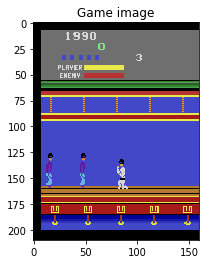

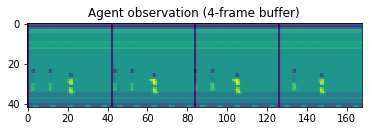

In [30]:
# 看看环境长什么样子

s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0,2,1]).reshape([42,-1]))
plt.show()

### 搭建如下的网络模型

其中网络的输出为 动作个数+1(Q值)

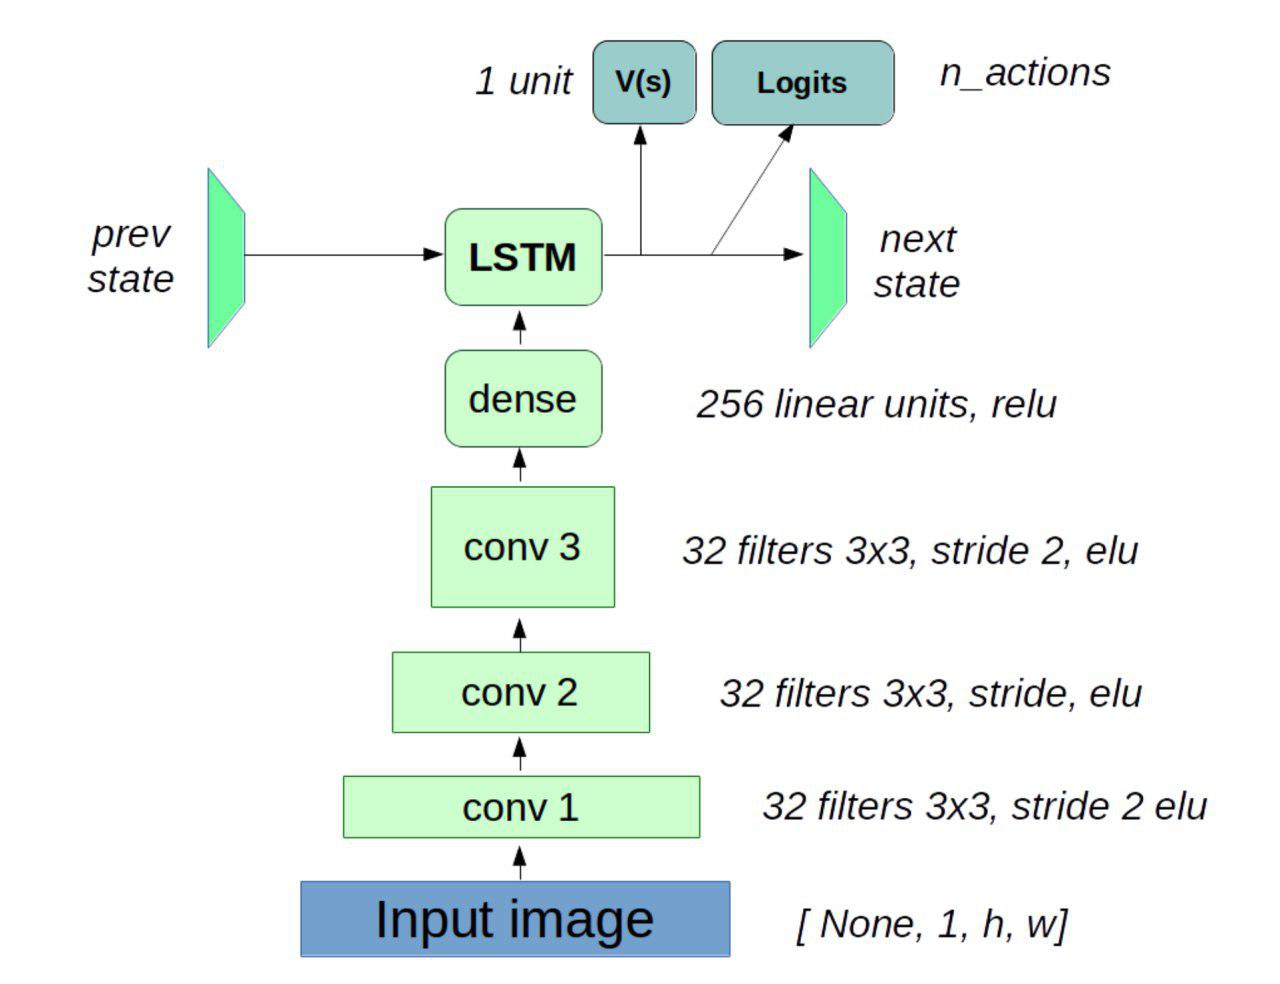

In [31]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [5]:
from keras.layers import Conv2D, Dense, Flatten
import keras

class Agent:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        
        with tf.variable_scope(name, reuse=reuse):
            
            self.network = keras.models.Sequential()
            
            self.network.add(Conv2D(16, (3, 3), strides=2, activation='relu', input_shape=state_shape))
            self.network.add(Conv2D(32, (3, 3), strides=2, activation='relu'))
            self.network.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
            self.network.add(Flatten())
            self.network.add(Dense(256, activation='relu'))
            
            self.network.add(Dense(n_actions+1, activation='linear'))
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)
        
    def symbolic_step(self, state_t):
        
        network_output = self.network(state_t)

        logits = network_output[:,1:]
        state_value = network_output[:,0]
        
        return (logits, state_value)
    
    def step(self, state_t):
        sess = tf.get_default_session()
        return sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

/Users/haxu/anaconda3/envs/deep-learning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
agent = Agent("agent", obs_shape, n_actions)
sess.run(tf.global_variables_initializer())

# 训练

In [7]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[ 0.02647825 -0.16687876 -0.02546277  0.05602987  0.05637595 -0.09788261
  -0.00252774 -0.06477063 -0.03780729 -0.10467525 -0.06287079  0.09871842
  -0.06798819 -0.0554052 ]]
state values:
 [0.0975327]


In [8]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        
        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done: break
                
        game_rewards.append(total_reward)
    return game_rewards

In [9]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print (rw)

[6.0, 9.0, 4.0]


## 如果没有训练的话，会怎么样

In [32]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[0])) #this may or may not be _last_ video. Try other indices

## 建立异步训练环境

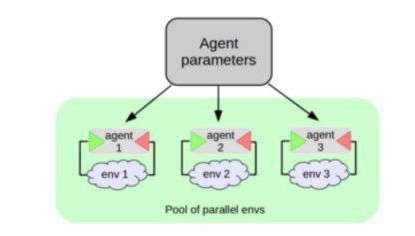

In [33]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

In [35]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()

batch_actions = agent.sample_actions(agent.step(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions[:3])
print("Rewards:", batch_rewards[:3])
print("Done:", batch_done[:3])

### 定义输入输出

In [13]:
states_ph = tf.placeholder('float32', [None,] + list(obs_shape))    
next_states_ph = tf.placeholder('float32', [None,] + list(obs_shape))
actions_ph = tf.placeholder('int32', (None,))
rewards_ph = tf.placeholder('float32', (None,))
is_done_ph = tf.placeholder('float32', (None,))

In [14]:
logits, state_values = agent.symbolic_step(states_ph)
next_logits, next_state_values = agent.symbolic_step(next_states_ph)
next_state_values = next_state_values * (1 - is_done_ph)

# 定义输出动作的概率
probs = tf.nn.softmax(logits)            # [n_envs, n_actions]
logprobs = tf.nn.log_softmax(logits)     # [n_envs, n_actions]

logp_actions = tf.reduce_sum(logprobs * tf.one_hot(actions_ph, n_actions), axis=-1) # [n_envs,]

## a3c

In [37]:
gamma = 0.99
advantage = rewards_ph + gamma*next_state_values - state_values



entropy =  -tf.reduce_sum(probs * logprobs, 1, name="entropy")



# 定义loss
actor_loss =  - tf.reduce_mean(logp_actions * tf.stop_gradient(advantage)) - 0.001 * tf.reduce_mean(entropy)

target_state_values = rewards_ph+gamma*next_state_values

critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2 )

train_step = tf.train.AdamOptimizer(1e-4).minimize(actor_loss + critic_loss)
sess.run(tf.global_variables_initializer())

In [39]:
l_act, l_crit, adv, ent = sess.run([actor_loss, critic_loss, advantage, entropy], feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    })

In [17]:
from IPython.display import clear_output
from tqdm import trange
from pandas import ewma
env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


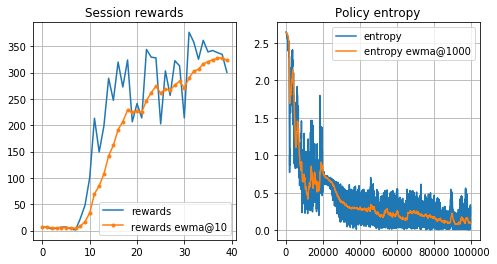

100%|██████████| 100000/100000 [47:58<00:00, 34.73it/s]


In [18]:
for i in trange(100000): 
    
    batch_actions = agent.sample_actions(agent.step(batch_states))
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
    
    feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_next_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    }
    batch_states = batch_next_states
    
    _, ent_t = sess.run([train_step, entropy], feed_dict)
    entropy_history.append(np.mean(ent_t))

    if i % 500 == 0: 
        if i % 2500 == 0:
            rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
            if rewards_history[-1] >= 50:
                print("Your agent has earned the yellow belt")

        clear_output(True)
        plt.figure(figsize=[8,4])
        plt.subplot(1,2,1)
        plt.plot(rewards_history, label='rewards')
        plt.plot(ewma(np.array(rewards_history),span=10), marker='.', label='rewards ewma@10')
        plt.title("Session rewards"); plt.grid(); plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(entropy_history, label='entropy')
        plt.plot(ewma(np.array(entropy_history),span=1000), label='entropy ewma@1000')
        plt.title("Policy entropy"); plt.grid(); plt.legend()        
        plt.show()

In [25]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=1,)
env_monitor.close()
print("Final mean reward:", np.mean(final_rewards))

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

Final mean reward: 544.0


In [26]:
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1]))